In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

szachy = pd.read_csv("krkopt.data",
                 header = None,
                 names = ['white-king-file','white-king-rank',
                          'white-rook-file','white-rook-rank',
                          'black-king-file','black-king-rank',
                          'white-depth-of-win'])

In [80]:
zamiana_liter = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
file_cols = ['white-king-file', 'white-rook-file', 'black-king-file']
for col in file_cols:
    szachy[col] = szachy[col].map(zamiana_liter)

In [81]:
depth_map = {
    'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14,
    'fifteen': 15, 'sixteen': 16
}
szachy['white-depth-of-win'] = szachy['white-depth-of-win'].map(depth_map)

## PYTANIE 1

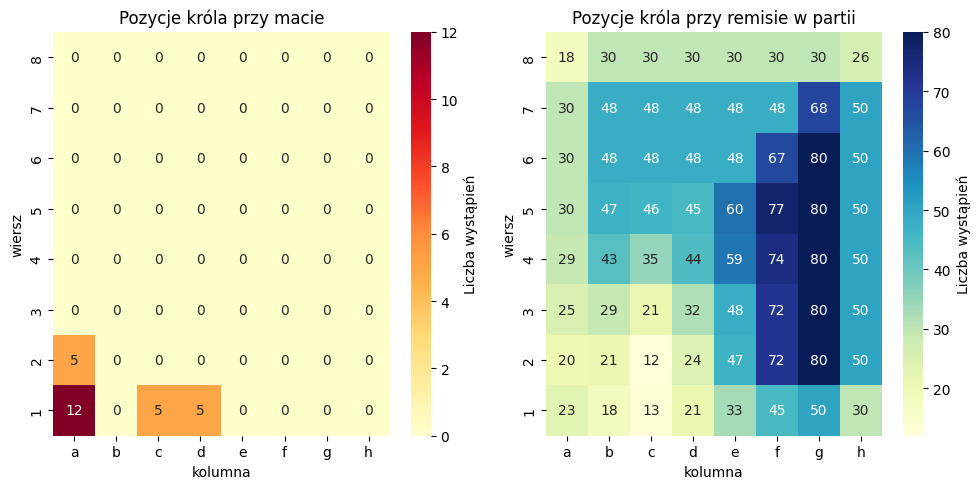

In [82]:
mat_data = szachy[szachy['white-depth-of-win'] == 0]
remis_data = szachy[szachy['white-depth-of-win'] == -1]

mat_count = mat_data.groupby(['black-king-rank', 'black-king-file']).size().unstack(fill_value=0)
mat_board = mat_count.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)
remis_count = remis_data.groupby(['black-king-rank', 'black-king-file']).size().unstack(fill_value=0)
remis_board = remis_count.reindex(index=range(1, 9), columns=range(1, 9), fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
sns.heatmap(mat_board, cmap="YlOrRd", ax=ax1, annot=True, fmt="d", cbar_kws={'label': 'Liczba wystąpień'})
ax1.set_title("Pozycje króla przy macie")
ax1.set_xlabel('kolumna')
ax1.set_ylabel('wiersz')
ax1.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
ax1.invert_yaxis()  

sns.heatmap(remis_board, cmap="YlGnBu", ax=ax2, annot=True, fmt="d", cbar_kws={'label': 'Liczba wystąpień'})
ax2.set_title("Pozycje króla przy remisie w partii")
ax2.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
ax2.set_xlabel('kolumna')
ax2.set_ylabel('wiersz')
ax2.invert_yaxis()
plt.tight_layout()
plt.show()

Na wykresie mozemy zaobserwowac, ze czarnego krola matujemy wylącznie w lewym dolnym rogu planszy. 
Najczęściej zdarza się to w polu A1.
 
Jeśli chodzi zaś o remis, sytuacja nie jest tkaa jednoznaczna. Na kazdym z pól szachownicy moze dojsc do remisu. Najczęściej zdarza się to w jej centrum, szczególnie po prawej stronie.

 ## PYTANIE 2

In [83]:
## przygotowanie danych.
df_2 = szachy[szachy['white-depth-of-win'] != -1].copy()
df_2 = df_2.rename(columns={'white-depth-of-win': 'result'})
x = (df_2['white-king-file'] - df_2['black-king-file']).abs()
y = (df_2['white-king-rank'] - df_2['black-king-rank']).abs()

df_2['Euklidesowa'] = np.sqrt(x**2 + y**2)
df_2['Manhattan'] = x + y
df_2['Czebyszewa'] = np.maximum(x, y)

metryki = ['Euklidesowa', 'Manhattan', 'Czebyszewa']
metody = ['pearson', 'spearman', 'kendall']

corr_results = []
for kor in metody:
    c = df_2[metryki + ['result']].corr(method=kor)['result'].drop('result')
    for m, val in c.items():
        corr_results.append({'Metryka': m, 'Metoda': kor.capitalize(), 'Korelacja': val})
df_kor = pd.DataFrame(corr_results)


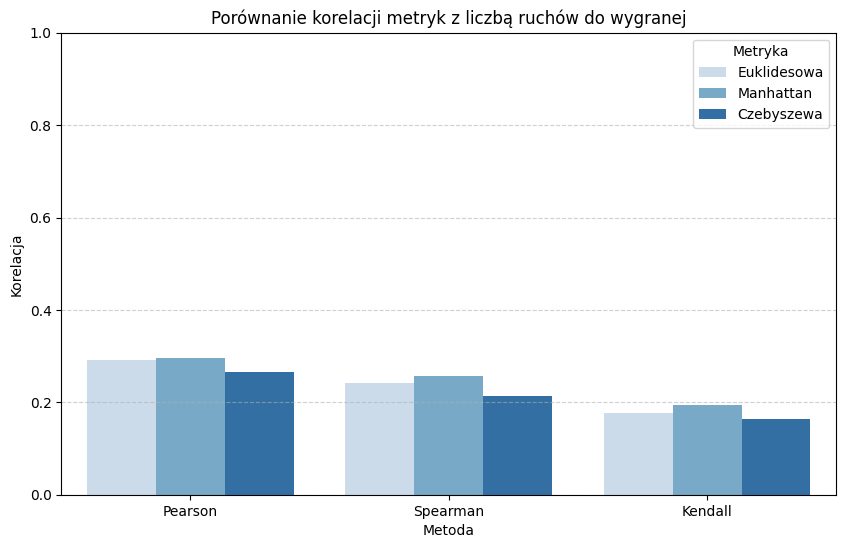

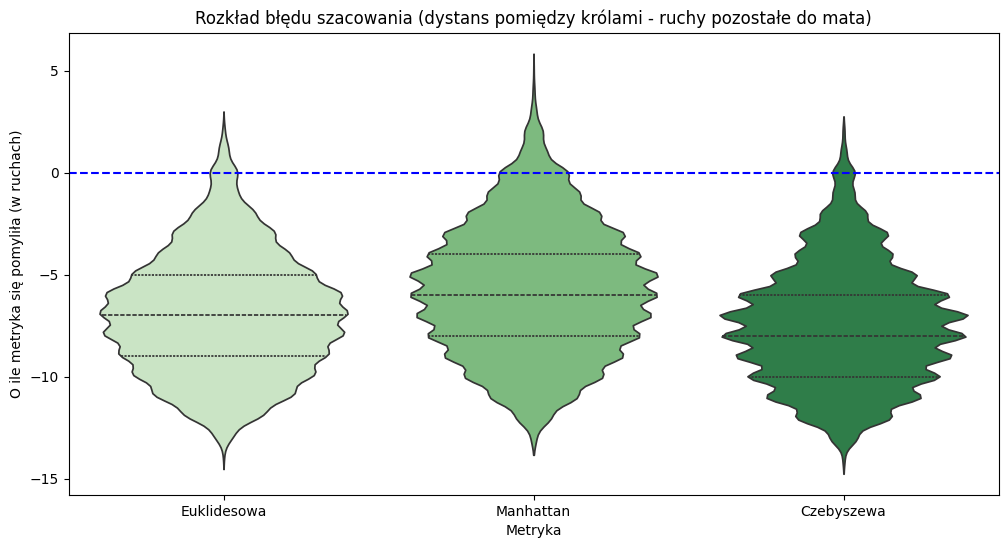

Zestawienie korelacji
Metoda        Kendall   Pearson  Spearman
Metryka                                  
Czebyszewa   0.164394  0.266009  0.212660
Euklidesowa  0.177547  0.290681  0.242819
Manhattan    0.193463  0.296696  0.256605


In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_kor, x='Metoda', y='Korelacja', hue='Metryka', palette='Blues')
plt.title('Porównanie korelacji metryk z liczbą ruchów do wygranej')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

for m in metryki:
    df_2[f'Err_{m}'] = df_2[m] - df_2['result']

df_euk = pd.DataFrame({'Błąd': df_2['Err_Euklidesowa'], 'Metryka': 'Euklidesowa'})
df_man = pd.DataFrame({'Błąd': df_2['Err_Manhattan'], 'Metryka': 'Manhattan'})
df_cze = pd.DataFrame({'Błąd': df_2['Err_Czebyszewa'], 'Metryka': 'Czebyszewa'})
df_2_long = pd.concat([df_euk, df_man, df_cze])

plt.figure(figsize=(12, 6))
sns.violinplot(data=df_2_long, x='Metryka', y='Błąd',hue='Metryka', inner="quart", palette='Greens')
plt.axhline(0, color='blue', linestyle='--', linewidth=1.5) 
plt.title('Rozkład błędu szacowania (dystans pomiędzy królami - ruchy pozostałe do mata)')
plt.ylabel('O ile metryka się pomyliła (w ruchach)')
plt.show()

print("Zestawienie korelacji")
print(df_kor.pivot(index='Metryka', columns='Metoda', values='Korelacja'))

Dla wszystkich z 3 zbadanych wsp. korelacji metryka Manhattan osiąga najlepsze wyniki (najwyszy wsp. kor.).
Jeśli chodzi o błędy szacowania, równiez przoduje.
Mozna więc jednogłośnie wybrać ją najlepszą metryką.

## PYTANIE 3

In [85]:
## przygotowanie danych.
df_3 = szachy[szachy['white-depth-of-win'] != -1].copy()
df_3 = df_3.rename(columns={'white-depth-of-win': 'result'})
df_3['dist_edge_file'] = np.minimum(df_3['black-king-file'] - 1, 8 - df_3['black-king-file'])
df_3['dist_edge_rank'] = np.minimum(df_3['black-king-rank'] - 1, 8 - df_3['black-king-rank'])
df_3['dist_to_edge'] = np.minimum(df_3['dist_edge_file'], df_3['dist_edge_rank'])

x = (df_3['white-king-file'] - df_3['black-king-file']).abs()
y = (df_3['white-king-rank'] - df_3['black-king-rank']).abs()

df_3['Manhattan'] = x + y
df_3['Czebyszewa'] = np.maximum(x, y)
df_3['Euklidesowa'] = np.sqrt(x**2 + y**2).round() # musimy zaokraglic aby umiescic dane w boxplocie

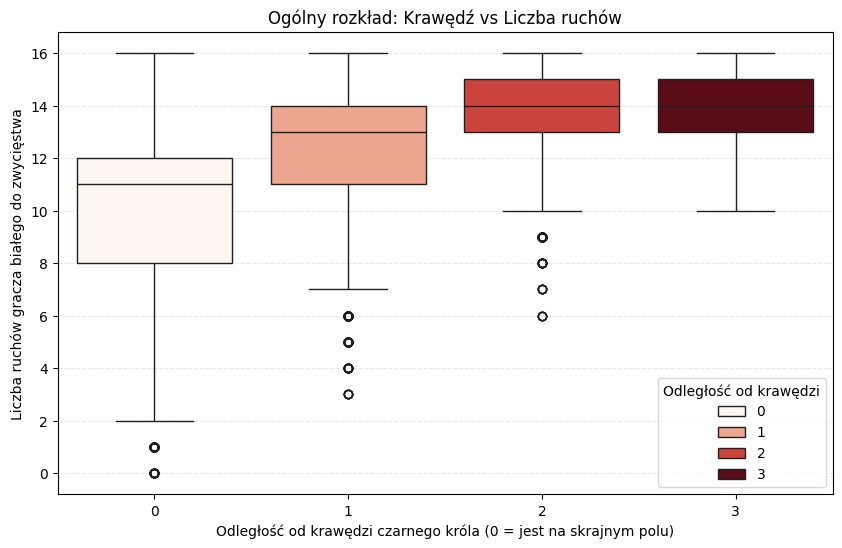

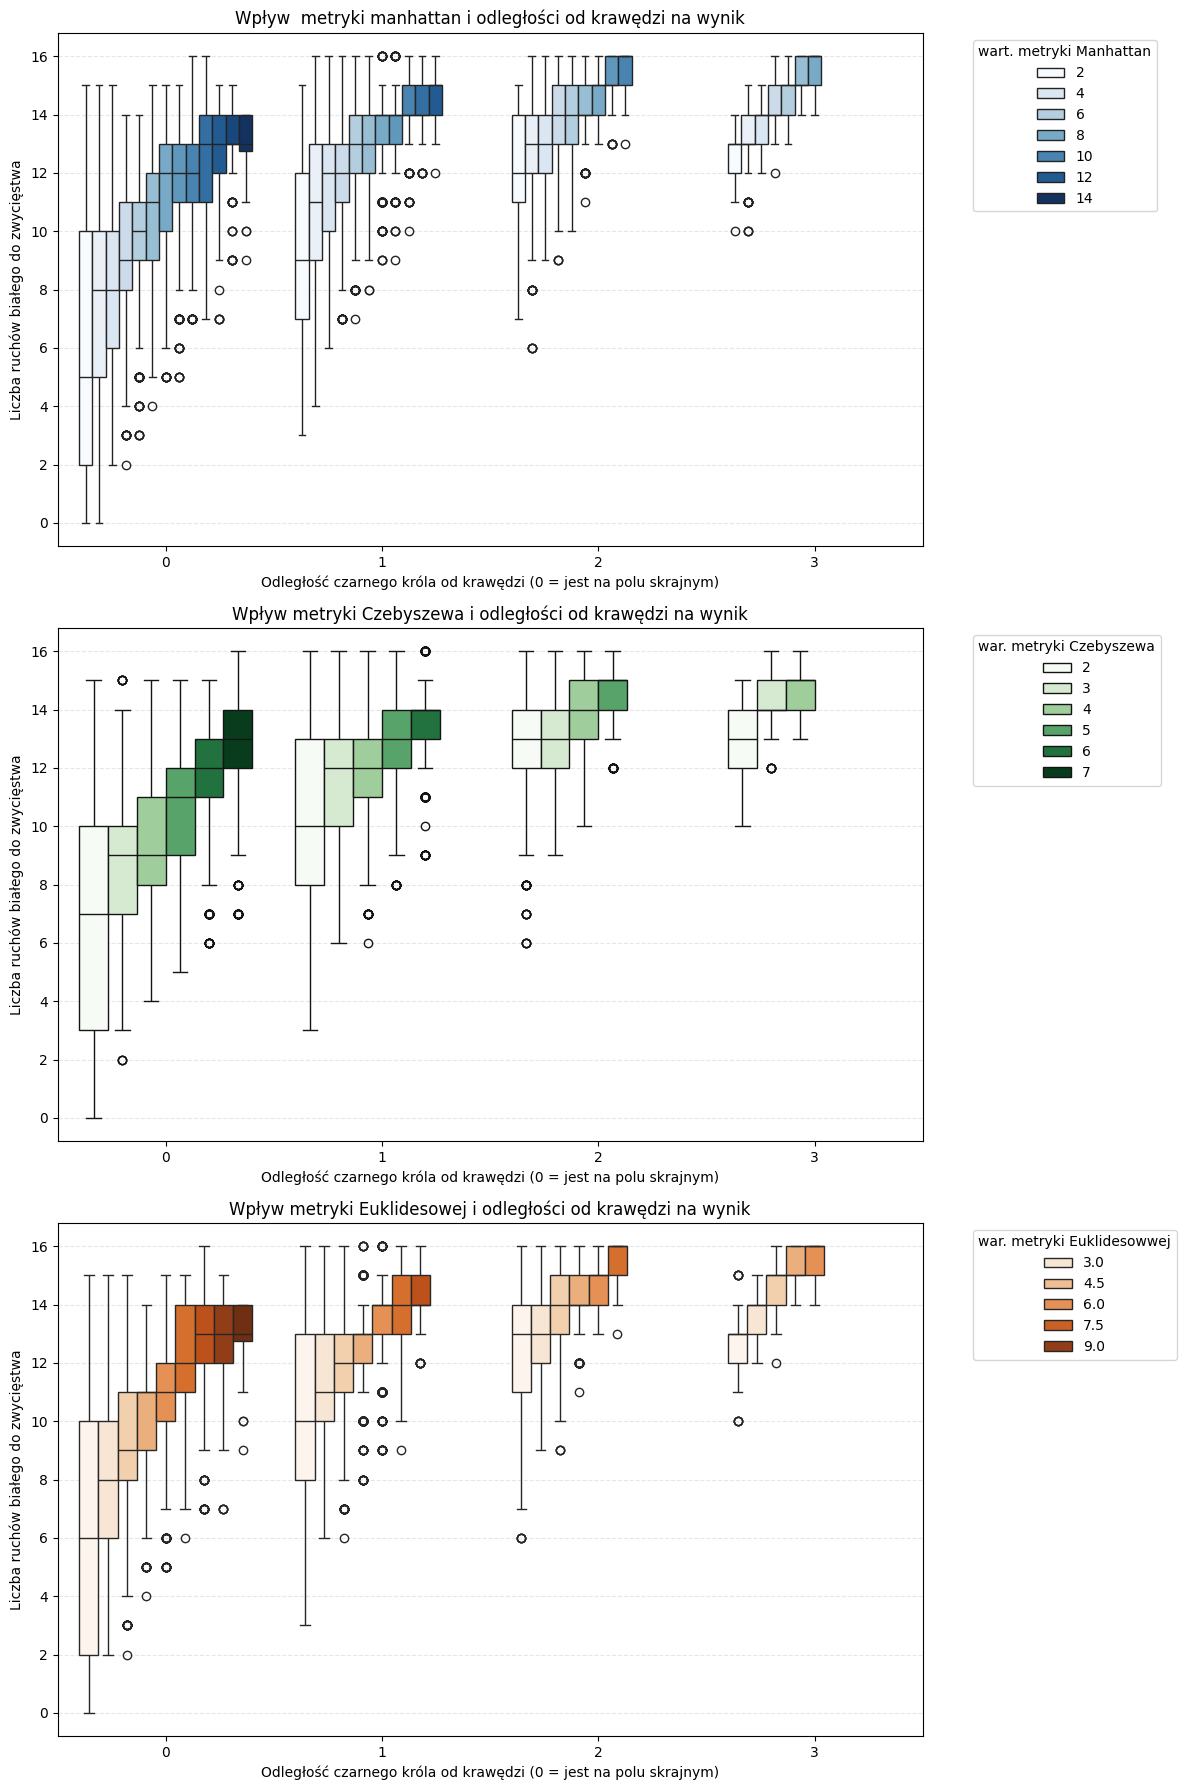

In [86]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_3, x='dist_to_edge', y='result', hue='dist_to_edge', palette='Reds')
plt.title('Ogólny rozkład: Krawędź vs Liczba ruchów')
plt.xlabel('Odległość od krawędzi czarnego króla (0 = jest na skrajnym polu)')
plt.ylabel('Liczba ruchów gracza białego do zwycięstwa')
plt.legend(title='Odległość od krawędzi', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(12, 18))

sns.boxplot(ax=axes[0], data=df_3, x='dist_to_edge', y='result', hue='Manhattan', palette='Blues')
axes[0].set_title('Wpływ  metryki manhattan i odległości od krawędzi na wynik')
axes[0].legend(title='wart. metryki Manhattan', bbox_to_anchor=(1.05, 1))

sns.boxplot(ax=axes[1], data=df_3, x='dist_to_edge', y='result', hue='Czebyszewa', palette='Greens')
axes[1].set_title('Wpływ metryki Czebyszewa i odległości od krawędzi na wynik')
axes[1].legend(title='war. metryki Czebyszewa', bbox_to_anchor=(1.05, 1))

sns.boxplot(ax=axes[2], data=df_3, x='dist_to_edge', y='result', hue='Euklidesowa', palette='Oranges')
axes[2].set_title('Wpływ metryki Euklidesowej i odległości od krawędzi na wynik')
axes[2].legend(title='war. metryki Euklidesowwej', bbox_to_anchor=(1.05, 1))
for ax in axes:
    ax.set_xlabel('Odległość czarnego króla od krawędzi (0 = jest na polu skrajnym)')
    ax.set_ylabel('Liczba ruchów białego do zwycięstwa')
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

OO to bardzo ciekawe. 
Widzimy wyraźną zalezność między odległością od krawędzi szachownicy czarnego króla, a liczbą ruchów do zakończenia rozgrywki - im blizej niej się znajduje, tym szybciej zakończymy naszą partię.

Dodatkowo dla danego dystansu od krawędzi gra kończy się najszybciej dla małej odległości pomiedzy królami, co mozemy zaobserwować dla kazdej z rozwazanych metryk.

Dla obu zadanych więc pytań odpowiadam: TAK!